# Our goal is to predict the Churn out of a bank.

This project was developed by:

- Jorge Rodrigo Velázquez
- Leandro Sartini de Campos
- Mohamed Maaz Rehan
- Aman Nain
- Prakash Pun
- Saraka Sahaswin
- Bibek Ranjit

Url -> https://github.com/RooVelazquez/Group1_Assessment6

## Dataset Description

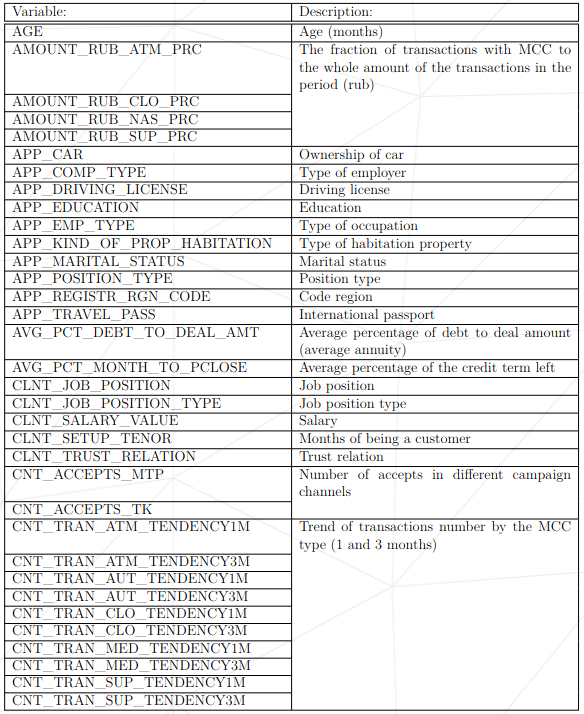

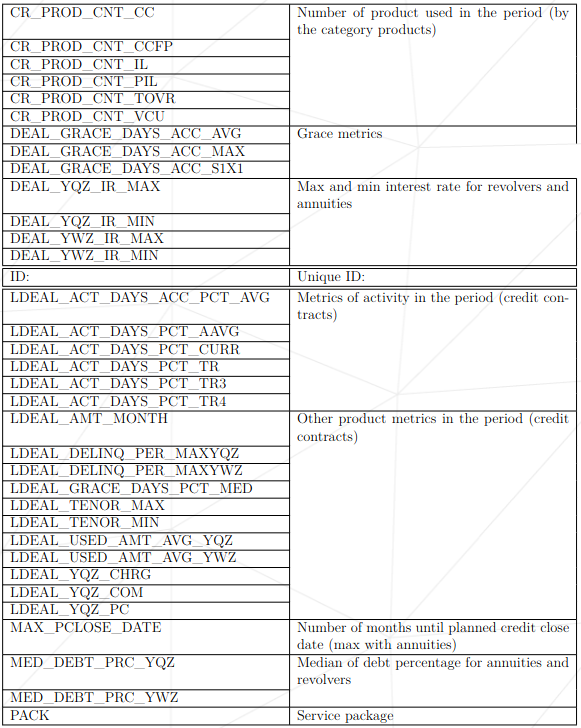

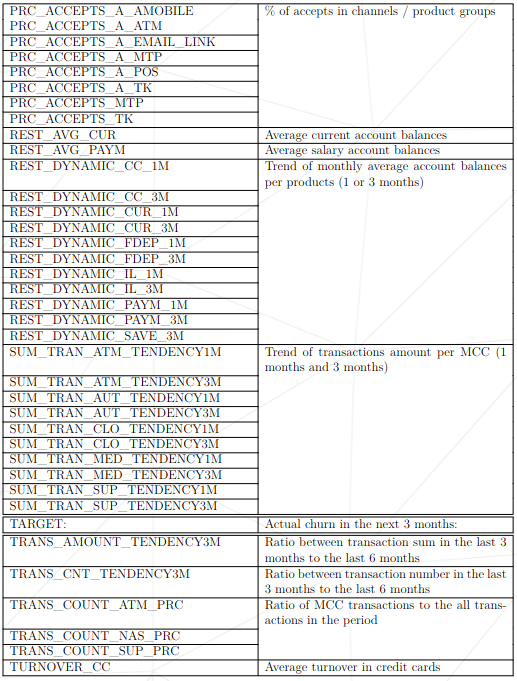

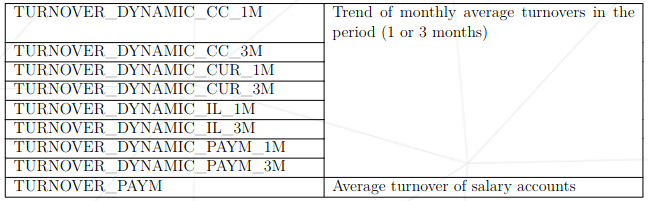

MECE Table

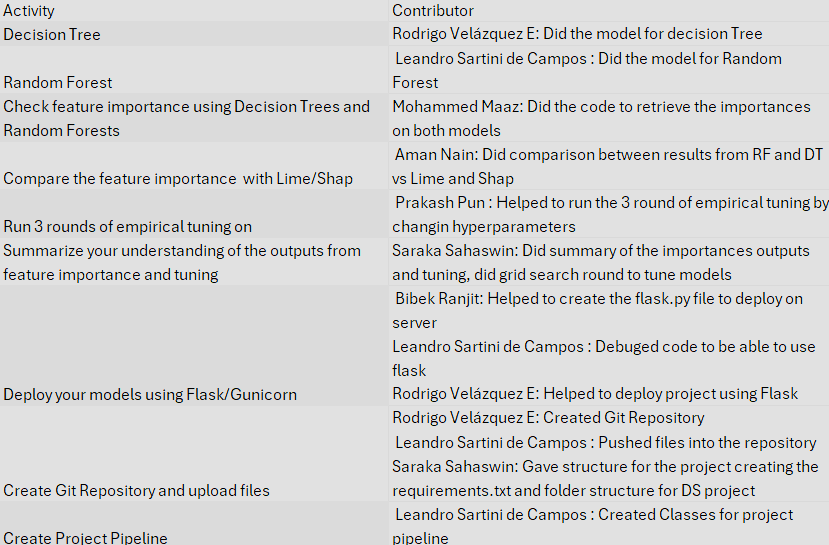

### Step by step of what we are going to do

## Importing all the necessary libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,roc_auc_score,f1_score,roc_curve,auc
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import NearMiss
import lime
from lime.lime_tabular import LimeTabularExplainer
import shap
import warnings
from SALib import ProblemSpec
import pickle
warnings.filterwarnings('ignore')

## Importing the file

In [9]:
df = pd.read_csv('../data/processed/first_preprocessed_df.csv')

In [10]:
df['PACK'].unique()

array(['K01', '102', '105', 'O01', '103', '101', '107', '301', '104',
       '108', '109', 'M01'], dtype=object)

In [11]:
df['AGE']=df['AGE']/12

### train test split

In [12]:
X_col = list(df.columns)

In [13]:
X_col.remove('TARGET')

In [14]:
X_train,X_test,y_train,y_test = train_test_split(df[X_col],df['TARGET'],test_size= 0.25,random_state=42)

Let's start with the ones that are concentrated

In [15]:
def get_mode(series):
    if not series.mode().empty:
        s = series.mode().iloc[0]  
        return s
    else:
        return None

In [16]:
imputation_dict = {
 'AMOUNT_RUB_CLO_PRC' :  X_train.groupby('PACK')['AMOUNT_RUB_CLO_PRC'].apply(get_mode).to_dict(),
 'AMOUNT_RUB_NAS_PRC' :  X_train.groupby('PACK')['AMOUNT_RUB_NAS_PRC'].apply(get_mode).to_dict(),
 'TRANS_COUNT_NAS_PRC' : X_train.groupby('PACK')['TRANS_COUNT_NAS_PRC'].apply(get_mode).to_dict()
}

In [17]:
pack_list = list(df['PACK'].unique())
pack_list.remove('108')
pack_list.remove('M01')
for item in df['PACK'].unique():
    X_train.loc[X_train['PACK']== item,'AMOUNT_RUB_CLO_PRC'] = imputation_dict['AMOUNT_RUB_CLO_PRC'][item]
    X_train.loc[X_train['PACK']== item,'AMOUNT_RUB_NAS_PRC'] = imputation_dict['AMOUNT_RUB_NAS_PRC'][item]
    X_train.loc[X_train['PACK']== item,'TRANS_COUNT_NAS_PRC'] = imputation_dict['TRANS_COUNT_NAS_PRC'][item]
    X_test.loc[X_test['PACK']== item,'AMOUNT_RUB_CLO_PRC'] = imputation_dict['AMOUNT_RUB_CLO_PRC'][item]
    X_test.loc[X_test['PACK']== item,'AMOUNT_RUB_NAS_PRC'] = imputation_dict['AMOUNT_RUB_NAS_PRC'][item]
    X_test.loc[X_test['PACK']== item,'TRANS_COUNT_NAS_PRC'] = imputation_dict['TRANS_COUNT_NAS_PRC'][item]

amount_clo = X_train['AMOUNT_RUB_CLO_PRC'].mode()[0]
amount_nas = X_train['AMOUNT_RUB_NAS_PRC'].mode()[0]
trans_nas = X_train['TRANS_COUNT_NAS_PRC'].mode()[0]
    
X_train['AMOUNT_RUB_CLO_PRC'].fillna(amount_clo,inplace = True)
X_train['AMOUNT_RUB_NAS_PRC'].fillna(amount_nas,inplace = True)
X_train['TRANS_COUNT_NAS_PRC'].fillna(trans_nas,inplace = True)
X_test['AMOUNT_RUB_CLO_PRC'].fillna(amount_clo,inplace = True)
X_test['AMOUNT_RUB_NAS_PRC'].fillna(amount_nas,inplace = True)
X_test['TRANS_COUNT_NAS_PRC'].fillna(trans_nas,inplace = True)

In [18]:
check = ['AMOUNT_RUB_CLO_PRC','AMOUNT_RUB_NAS_PRC','TRANS_COUNT_NAS_PRC']

In [19]:
X_train[check].isnull().sum()

AMOUNT_RUB_CLO_PRC     0
AMOUNT_RUB_NAS_PRC     0
TRANS_COUNT_NAS_PRC    0
dtype: int64

Let's go to the Skewed ones now

In [20]:
imputation_dict.update({
 'AMOUNT_RUB_SUP_PRC' :  X_train.groupby('PACK')['AMOUNT_RUB_SUP_PRC'].median().to_dict(),
 'TRANS_COUNT_SUP_PRC' :  X_train.groupby('PACK')['TRANS_COUNT_SUP_PRC'].median().to_dict(),
 'TRANS_COUNT_ATM_PRC' : X_train.groupby('PACK')['TRANS_COUNT_ATM_PRC'].median().to_dict(),
 'AMOUNT_RUB_ATM_PRC' :  X_train.groupby('PACK')['AMOUNT_RUB_ATM_PRC'].median().to_dict(),
 'CNT_TRAN_ATM_TENDENCY1M' :  X_train.groupby('PACK')['CNT_TRAN_ATM_TENDENCY1M'].median().to_dict(),
 'SUM_TRAN_ATM_TENDENCY1M' :  X_train.groupby('PACK')['SUM_TRAN_ATM_TENDENCY1M'].median().to_dict()
})

In [21]:
pack_list = list(df['PACK'].unique())
pack_list.remove('108')
pack_list.remove('M01')
for item in df['PACK'].unique():
    X_train.loc[X_train['PACK']== item,'AMOUNT_RUB_SUP_PRC'] = imputation_dict['AMOUNT_RUB_SUP_PRC'][item]
    X_train.loc[X_train['PACK']== item,'TRANS_COUNT_SUP_PRC'] = imputation_dict['TRANS_COUNT_SUP_PRC'][item]
    X_train.loc[X_train['PACK']== item,'TRANS_COUNT_ATM_PRC'] = imputation_dict['TRANS_COUNT_ATM_PRC'][item]
    X_train.loc[X_train['PACK']== item,'AMOUNT_RUB_ATM_PRC'] = imputation_dict['AMOUNT_RUB_ATM_PRC'][item]
    X_train.loc[X_train['PACK']== item,'CNT_TRAN_ATM_TENDENCY1M'] = imputation_dict['CNT_TRAN_ATM_TENDENCY1M'][item]
    X_train.loc[X_train['PACK']== item,'SUM_TRAN_ATM_TENDENCY1M'] = imputation_dict['SUM_TRAN_ATM_TENDENCY1M'][item]
    X_test.loc[X_test['PACK']== item,'AMOUNT_RUB_SUP_PRC'] = imputation_dict['AMOUNT_RUB_SUP_PRC'][item]
    X_test.loc[X_test['PACK']== item,'TRANS_COUNT_SUP_PRC'] = imputation_dict['TRANS_COUNT_SUP_PRC'][item]
    X_test.loc[X_test['PACK']== item,'TRANS_COUNT_ATM_PRC'] = imputation_dict['TRANS_COUNT_ATM_PRC'][item]
    X_test.loc[X_test['PACK']== item,'AMOUNT_RUB_ATM_PRC'] = imputation_dict['AMOUNT_RUB_ATM_PRC'][item]
    X_test.loc[X_test['PACK']== item,'CNT_TRAN_ATM_TENDENCY1M'] = imputation_dict['CNT_TRAN_ATM_TENDENCY1M'][item]
    X_test.loc[X_test['PACK']== item,'SUM_TRAN_ATM_TENDENCY1M'] = imputation_dict['SUM_TRAN_ATM_TENDENCY1M'][item]

median_1 = X_train['AMOUNT_RUB_SUP_PRC'].median()
median_2 = X_train['TRANS_COUNT_SUP_PRC'].median()
median_3 = X_train['TRANS_COUNT_ATM_PRC'].median()
median_4 = X_train['AMOUNT_RUB_ATM_PRC'].median()
median_5 = X_train['CNT_TRAN_ATM_TENDENCY1M'].median()
median_6 = X_train['SUM_TRAN_ATM_TENDENCY1M'].median()
    
X_train['AMOUNT_RUB_SUP_PRC'].fillna(median_1,inplace = True)
X_train['TRANS_COUNT_SUP_PRC'].fillna(median_2,inplace = True)
X_train['TRANS_COUNT_ATM_PRC'].fillna(median_3,inplace = True)
X_train['AMOUNT_RUB_ATM_PRC'].fillna(median_4,inplace = True)
X_train['CNT_TRAN_ATM_TENDENCY1M'].fillna(median_5,inplace = True)
X_train['SUM_TRAN_ATM_TENDENCY1M'].fillna(median_6,inplace = True)
X_test['AMOUNT_RUB_SUP_PRC'].fillna(median_1,inplace = True)
X_test['TRANS_COUNT_SUP_PRC'].fillna(median_2,inplace = True)
X_test['TRANS_COUNT_ATM_PRC'].fillna(median_3,inplace = True)
X_test['AMOUNT_RUB_ATM_PRC'].fillna(median_4,inplace = True)
X_test['CNT_TRAN_ATM_TENDENCY1M'].fillna(median_5,inplace = True)
X_test['SUM_TRAN_ATM_TENDENCY1M'].fillna(median_6,inplace = True)

In [22]:
check = ['AMOUNT_RUB_SUP_PRC'
,'TRANS_COUNT_SUP_PRC'
,'TRANS_COUNT_ATM_PRC'
,'AMOUNT_RUB_ATM_PRC'
,'CNT_TRAN_ATM_TENDENCY1M'
,'SUM_TRAN_ATM_TENDENCY1M']

In [23]:
X_train[check].isnull().sum()

AMOUNT_RUB_SUP_PRC         0
TRANS_COUNT_SUP_PRC        0
TRANS_COUNT_ATM_PRC        0
AMOUNT_RUB_ATM_PRC         0
CNT_TRAN_ATM_TENDENCY1M    0
SUM_TRAN_ATM_TENDENCY1M    0
dtype: int64

Let's go to the Normal ones ones now

In [24]:
imputation_dict.update({
 'CNT_TRAN_SUP_TENDENCY3M' :  X_train.groupby('PACK')['CNT_TRAN_SUP_TENDENCY3M'].mean().to_dict(),
 'SUM_TRAN_SUP_TENDENCY3M' :  X_train.groupby('PACK')['SUM_TRAN_SUP_TENDENCY3M'].mean().to_dict(),
 'CNT_TRAN_ATM_TENDENCY3M' : X_train.groupby('PACK') ['CNT_TRAN_ATM_TENDENCY3M'].mean().to_dict(),
 'AMOUNT_RUB_ATM_PRC' :  X_train.groupby('PACK')['AMOUNT_RUB_ATM_PRC'].mean().to_dict(),
 'SUM_TRAN_ATM_TENDENCY3M' :  X_train.groupby('PACK')['SUM_TRAN_ATM_TENDENCY3M'].mean().to_dict(),
 'TRANS_AMOUNT_TENDENCY3M' :  X_train.groupby('PACK')['TRANS_AMOUNT_TENDENCY3M'].mean().to_dict(),
 'TRANS_CNT_TENDENCY3M' :  X_train.groupby('PACK')['TRANS_CNT_TENDENCY3M'].mean().to_dict()
})

In [25]:
pack_list = list(df['PACK'].unique())
pack_list.remove('108')
pack_list.remove('M01')
for item in df['PACK'].unique():
    X_train.loc[X_train['PACK']== item,'CNT_TRAN_SUP_TENDENCY3M'] = imputation_dict['CNT_TRAN_SUP_TENDENCY3M'][item]
    X_train.loc[X_train['PACK']== item,'SUM_TRAN_SUP_TENDENCY3M'] = imputation_dict['SUM_TRAN_SUP_TENDENCY3M'][item]
    X_train.loc[X_train['PACK']== item,'CNT_TRAN_ATM_TENDENCY3M'] = imputation_dict['CNT_TRAN_ATM_TENDENCY3M'][item]
    X_train.loc[X_train['PACK']== item,'AMOUNT_RUB_ATM_PRC'] = imputation_dict['AMOUNT_RUB_ATM_PRC'][item]
    X_train.loc[X_train['PACK']== item,'SUM_TRAN_ATM_TENDENCY3M'] = imputation_dict['SUM_TRAN_ATM_TENDENCY3M'][item]
    X_train.loc[X_train['PACK']== item,'TRANS_AMOUNT_TENDENCY3M'] = imputation_dict['TRANS_AMOUNT_TENDENCY3M'][item]
    X_train.loc[X_train['PACK']== item,'TRANS_CNT_TENDENCY3M'] = imputation_dict['TRANS_CNT_TENDENCY3M'][item]
    X_test.loc[X_test['PACK']== item,'CNT_TRAN_SUP_TENDENCY3M'] = imputation_dict['CNT_TRAN_SUP_TENDENCY3M'][item]
    X_test.loc[X_test['PACK']== item,'SUM_TRAN_SUP_TENDENCY3M'] = imputation_dict['SUM_TRAN_SUP_TENDENCY3M'][item]
    X_test.loc[X_test['PACK']== item,'CNT_TRAN_ATM_TENDENCY3M'] = imputation_dict['CNT_TRAN_ATM_TENDENCY3M'][item]
    X_test.loc[X_test['PACK']== item,'AMOUNT_RUB_ATM_PRC'] = imputation_dict['AMOUNT_RUB_ATM_PRC'][item]
    X_test.loc[X_test['PACK']== item,'SUM_TRAN_ATM_TENDENCY3M'] = imputation_dict['SUM_TRAN_ATM_TENDENCY3M'][item]
    X_test.loc[X_test['PACK']== item,'TRANS_AMOUNT_TENDENCY3M'] = imputation_dict['TRANS_AMOUNT_TENDENCY3M'][item]
    X_test.loc[X_test['PACK']== item,'TRANS_CNT_TENDENCY3M'] = imputation_dict['TRANS_CNT_TENDENCY3M'][item]

mean_1 = X_train['CNT_TRAN_SUP_TENDENCY3M'].mean()
mean_2 = X_train['SUM_TRAN_SUP_TENDENCY3M'].mean()
mean_3 = X_train['CNT_TRAN_ATM_TENDENCY3M'].mean()
mean_4 = X_train['AMOUNT_RUB_ATM_PRC'].mean()
mean_5 = X_train['SUM_TRAN_ATM_TENDENCY3M'].mean()
mean_6 = X_train['TRANS_AMOUNT_TENDENCY3M'].mean()
mean_7 = X_train['TRANS_CNT_TENDENCY3M'].mean()
    
X_train['CNT_TRAN_SUP_TENDENCY3M'].fillna(mean_1,inplace = True)
X_train['SUM_TRAN_SUP_TENDENCY3M'].fillna(mean_2,inplace = True)
X_train['CNT_TRAN_ATM_TENDENCY3M'].fillna(mean_3,inplace = True)
X_train['AMOUNT_RUB_ATM_PRC'].fillna(mean_4,inplace = True)
X_train['SUM_TRAN_ATM_TENDENCY3M'].fillna(mean_5,inplace = True)
X_train['TRANS_AMOUNT_TENDENCY3M'].fillna(mean_6,inplace = True)
X_train['TRANS_CNT_TENDENCY3M'].fillna(mean_7,inplace = True)
X_test['CNT_TRAN_SUP_TENDENCY3M'].fillna(mean_1,inplace = True)
X_test['SUM_TRAN_SUP_TENDENCY3M'].fillna(mean_2,inplace = True)
X_test['CNT_TRAN_ATM_TENDENCY3M'].fillna(mean_3,inplace = True)
X_test['AMOUNT_RUB_ATM_PRC'].fillna(mean_4,inplace = True)
X_test['SUM_TRAN_ATM_TENDENCY3M'].fillna(mean_5,inplace = True)
X_test['TRANS_AMOUNT_TENDENCY3M'].fillna(mean_6,inplace = True)
X_test['TRANS_CNT_TENDENCY3M'].fillna(mean_7,inplace = True)

In [26]:
check = ['CNT_TRAN_SUP_TENDENCY3M'
,'SUM_TRAN_SUP_TENDENCY3M'
,'CNT_TRAN_ATM_TENDENCY3M'
,'AMOUNT_RUB_ATM_PRC'
,'SUM_TRAN_ATM_TENDENCY3M'
,'TRANS_AMOUNT_TENDENCY3M'
,'TRANS_CNT_TENDENCY3M']

In [27]:
X_train[check].isnull().sum()

CNT_TRAN_SUP_TENDENCY3M    0
SUM_TRAN_SUP_TENDENCY3M    0
CNT_TRAN_ATM_TENDENCY3M    0
AMOUNT_RUB_ATM_PRC         0
SUM_TRAN_ATM_TENDENCY3M    0
TRANS_AMOUNT_TENDENCY3M    0
TRANS_CNT_TENDENCY3M       0
dtype: int64

In [28]:
Q1,Q3=np.percentile(X_train['REST_AVG_CUR'],[25,75])

In [29]:
IQR = Q3 - Q1

In [30]:
X_train = pd.merge(X_train,y_train,left_index = True,right_index = True)

In [31]:
X_train.loc[(X_train['REST_AVG_CUR']>= (IQR*2.1)) & (X_train['TARGET'] == 1),'REST_AVG_CUR']= IQR*2.1

In [32]:
X_train.loc[(X_train['CLNT_SETUP_TENOR']>= (IQR*2.1)) & (X_train['TARGET'] == 1),'CLNT_SETUP_TENOR']= IQR*2.1

In [33]:
X_train.drop(columns = 'TARGET',inplace = True)

In [34]:
df_analysis = pd.merge(X_train,y_train,left_index=True,right_index =True)

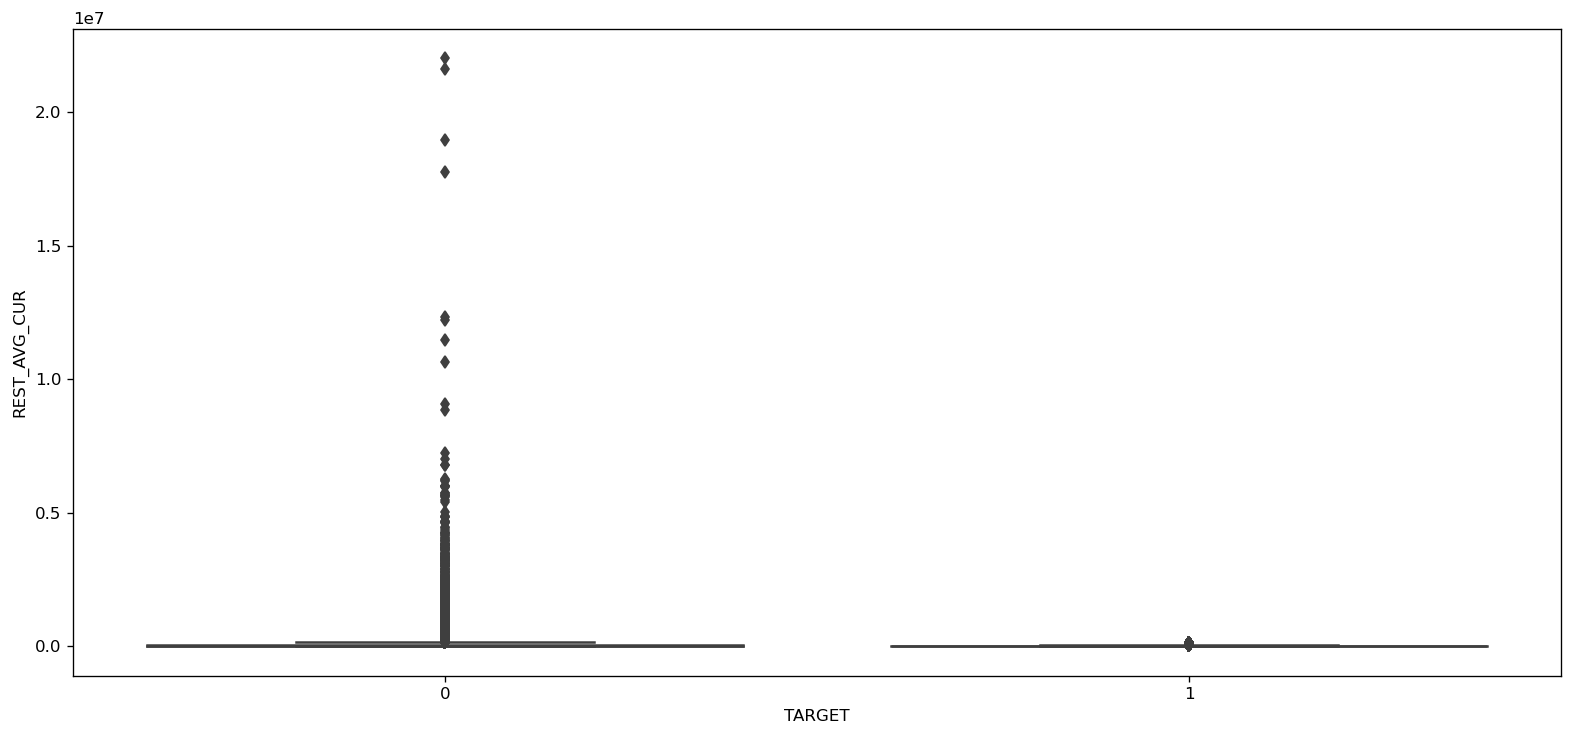

In [35]:
plt.figure(figsize=[16,7],dpi=120)
sns.boxplot(df_analysis,x='TARGET',y='REST_AVG_CUR')
plt.show()

## As we can see the outliers have been cleared for this column

We have to apply Onehot to the categorical, otherwise Standard Scaler won't work

In [36]:
oneh = OneHotEncoder(sparse_output=False)
oneh.fit(X_train[['PACK']])

OneHotEncoder(sparse_output=False)

In [37]:
col_names = oneh.get_feature_names_out()

In [38]:
X_train_dummies = pd.DataFrame(oneh.transform(X_train[['PACK']]),columns = col_names)
X_train_dummies.index = X_train.index
X_train = pd.merge(X_train,X_train_dummies,left_index=True,right_index=True)

X_test_dummies = pd.DataFrame(oneh.transform(X_test[['PACK']]),columns = col_names)
X_test_dummies.index = X_test.index
X_test = pd.merge(X_test,X_test_dummies,left_index=True,right_index=True)

In [39]:
X_train.drop(columns = 'PACK',inplace = True)
X_test.drop(columns = 'PACK',inplace = True)

Now to scale we are using the Standard Scaler

In [40]:
scaler = StandardScaler()

In [41]:
scaler.fit(X_train)

StandardScaler()

In [42]:
X_train_scaled = scaler.transform(X_train)
X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

In [43]:
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

Below we will create a list of columns that we will be using

In [44]:
cols_to_use = ['CR_PROD_CNT_IL', 'TURNOVER_DYNAMIC_IL_1M', 'REST_DYNAMIC_FDEP_1M',
       'REST_AVG_CUR', 'CR_PROD_CNT_PIL', 'TRANS_COUNT_ATM_PRC', 'AGE',
       'REST_DYNAMIC_IL_1M', 'REST_DYNAMIC_CUR_1M', 'REST_AVG_PAYM',
       'CNT_TRAN_SUP_TENDENCY3M', 'REST_DYNAMIC_PAYM_3M',
       'CNT_TRAN_ATM_TENDENCY3M', 'CLNT_SETUP_TENOR', 'REST_DYNAMIC_CC_1M',
       'PACK_101', 'PACK_102', 'PACK_103', 'PACK_104', 'PACK_105', 'PACK_107',
       'PACK_108', 'PACK_109', 'PACK_301', 'PACK_K01', 'PACK_M01', 'PACK_O01']

In [45]:
X_train = X_train[cols_to_use].copy()
X_test = X_test[cols_to_use].copy()

In [46]:
from imblearn.under_sampling import RandomUnderSampler

# Define the undersampler
rus = RandomUnderSampler()

# Resample the dataset
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [47]:
y_resampled = y_resampled.to_frame()

In [48]:
y_resampled.groupby(['TARGET']).size()

TARGET
0    21711
1    21711
dtype: int64

In [49]:
X_train = X_resampled
y_train = y_resampled

### Logistic Regression

In [50]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [51]:
#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,dt.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,dt.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,dt.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,dt.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,dt.predict(X_train))))
print()

Accuracy of training is 0.9999769701994381
Precision of training is 1.0
Recall of training is 0.9999539403988762
F1 of training is 0.9999769696690541
ROC AUC of training is 0.9999769701994381



In [52]:
#Printing errors
print('Accuracy of test is '+ str(accuracy_score(y_test,dt.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,dt.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,dt.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,dt.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,dt.predict(X_test))))
print()

Accuracy of test is 0.6521092817405797
Precision of test is 0.137018641157714
Recall of test is 0.6194898807873579
F1 of test is 0.2244037157921165
ROC AUC of test is 0.6372417534942869



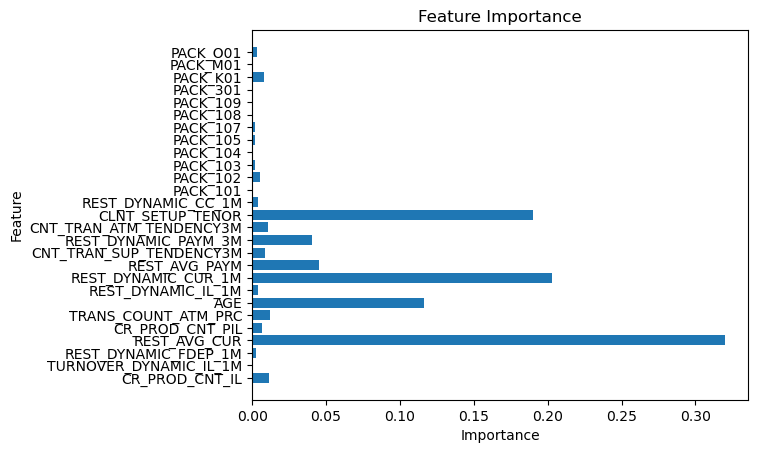

In [53]:
importances = dt.feature_importances_
feature_names = X_train.columns
feature_importance_dict = dict(zip(feature_names, importances))

plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [54]:
# export the tree visualization
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(dt, out_file='tree.dot', 
                feature_names=X_train.columns,
                class_names=y_train['TARGET'].astype(str).unique(),
                rounded=True, proportion=False, 
                precision=2, filled=True)



In [55]:
from graphviz import render

# Convert DOT to PNG
render('dot', 'png', 'tree.dot')


(process:10856): GLib-GIO-WARNING **: 16:54:18.893: Unexpectedly, UWP app `Microsoft.OutlookForWindows_1.2023.1214.201_x64__8wekyb3d8bbwe' (AUMId `Microsoft.OutlookForWindows_8wekyb3d8bbwe!Microsoft.OutlookforWindows') supports 1 extensions but has no verbs

(process:10856): GLib-GIO-WARNING **: 16:54:19.069: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2401.37.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs

(process:10856): GLib-GIO-WARNING **: 16:54:19.081: Unexpectedly, UWP app `Clipchamp.Clipchamp_3.0.10220.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0780191 to fit


'tree.dot.png'

In [56]:
import graphviz

In [57]:
print(graphviz.__file__)

C:\Users\leand\anaconda3\Lib\site-packages\graphviz\__init__.py


Our first iteration shown us that our tree is getting the maximum divisions and nodes it can have, so it got a very long overfitted decision tree which we will have to do some hyperparameter tuning

In [58]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
print('Accuracy of training is '+ str(accuracy_score(y_train,rf.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,rf.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,rf.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,rf.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_test,dt.predict(X_test))))

Accuracy of training is 0.9999769701994381
Precision of training is 0.9999539425202653
Recall of training is 1.0
F1 of training is 0.9999769707297975
ROC AUC of training is 0.6372417534942869


In [59]:
#Printing errors
print('Accuracy of test is '+ str(accuracy_score(y_test,rf.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,rf.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,rf.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,rf.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,rf.predict(X_test))))
print()

Accuracy of test is 0.6910178157165702
Precision of test is 0.1706244503078276
Recall of test is 0.7260881619074022
F1 of test is 0.27631683063856727
ROC AUC of test is 0.7070024551447189



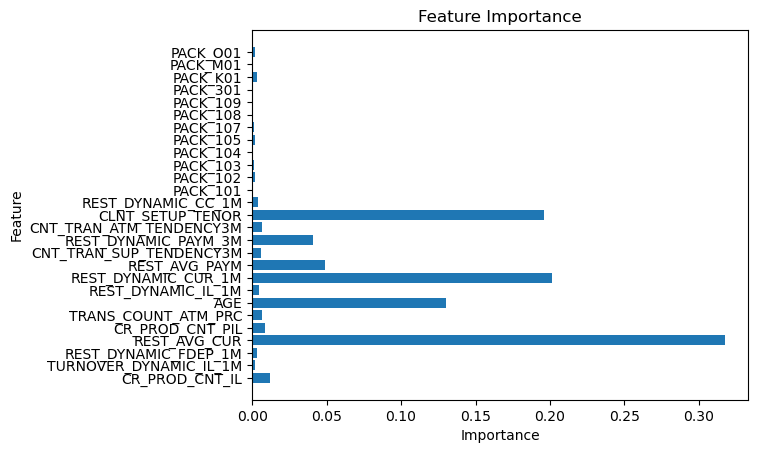

In [60]:
# Feature importances can also be retrieved to understand the contribution of each feature
importances = rf.feature_importances_
feature_names = X_train.columns
feature_importance_dict = dict(zip(feature_names, importances))



plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

Let's compare with Shap and Lime

<b> Results from Shap

![Shap Importance](../references/shap_feature_importance.png)

<b> Results from SALib

![SALib Feature Importance](../references/salib_sensitivity.png)

As we can see the Decision Trees and Random Forest are both giving importance to the same variables after tuning 5 times our model.

In [61]:
dt = DecisionTreeClassifier(random_state=42,max_depth = 3,min_samples_leaf=2000)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=2000, random_state=42)

In [62]:
#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,dt.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,dt.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,dt.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,dt.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,dt.predict(X_train))))
print()

Accuracy of training is 0.6894661692229745
Precision of training is 0.6817318312348133
Recall of training is 0.7107457049421952
F1 of training is 0.6959364993460515
ROC AUC of training is 0.6894661692229745



In [63]:
#Printing errors
print('Accuracy of test is '+ str(accuracy_score(y_test,dt.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,dt.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,dt.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,dt.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,dt.predict(X_test))))
print()

Accuracy of test is 0.671197549494358
Precision of test is 0.15797989855929304
Recall of test is 0.7037704463543111
F1 of test is 0.2580366445579528
ROC AUC of test is 0.6860438817376577



In [64]:
# export the tree visualization
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(dt, out_file='tree2.dot', 
                feature_names=X_train.columns,
                class_names=y_train['TARGET'].astype(str).unique(),
                rounded=True, proportion=False, 
                precision=2, filled=True)

In [65]:
from graphviz import render

# Convert DOT to PNG
render('dot', 'png', 'tree2.dot')

'tree2.dot.png'

![DT](../references/tree2.dot.png)

In [66]:
rf = RandomForestClassifier(n_estimators=100, random_state=42,max_depth = 3,min_samples_leaf=2000)
rf.fit(X_train, y_train)

# Evaluate the model
print('Accuracy of training is '+ str(accuracy_score(y_train,rf.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,rf.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,rf.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,rf.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_test,dt.predict(X_test))))

Accuracy of training is 0.6824190502510248
Precision of training is 0.6699420725166273
Recall of training is 0.7191285523467367
F1 of training is 0.6936644748533854
ROC AUC of training is 0.6860438817376577


In [67]:
#Printing errors
print('Accuracy of test is '+ str(accuracy_score(y_test,rf.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,rf.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,rf.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,rf.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,rf.predict(X_test))))
print()

Accuracy of test is 0.6500934705736615
Precision of test is 0.15081525716460292
Recall of test is 0.7141668976989187
F1 of test is 0.2490392749244713
ROC AUC of test is 0.6792973633424972



As we reduced the depth now we can see the decision tree, and also our minimum split wasn't so good so we will try changing it

In [68]:
dt = DecisionTreeClassifier(random_state=42,max_depth = 5,min_samples_leaf=1800)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=1800, random_state=42)

In [69]:
#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,dt.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,dt.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,dt.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,dt.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,dt.predict(X_train))))
print()

Accuracy of training is 0.7061397448298098
Precision of training is 0.6838818357368832
Recall of training is 0.7666620607065543
F1 of training is 0.7229098805646037
ROC AUC of training is 0.7061397448298098



In [70]:
#Printing errors
print('Accuracy of test is '+ str(accuracy_score(y_test,dt.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,dt.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,dt.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,dt.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,dt.predict(X_test))))
print()

Accuracy of test is 0.6516025135701254
Precision of test is 0.15742960288808663
Recall of test is 0.7556140837260882
F1 of test is 0.2605702813164751
ROC AUC of test is 0.6990097286643777



In [71]:
# export the tree visualization
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(dt, out_file='tree3.dot', 
                feature_names=X_train.columns,
                class_names=y_train['TARGET'].astype(str).unique(),
                rounded=True, proportion=False, 
                precision=2, filled=True)

In [72]:
from graphviz import render

# Convert DOT to PNG
render('dot', 'png', 'tree3.dot')

'tree3.dot.png'

![DT](../references/tree3.dot.png)

In [73]:
rf = RandomForestClassifier(n_estimators=500, random_state=42,max_depth = 5,min_samples_leaf=1800)
rf.fit(X_train, y_train)

# Evaluate the model
print('Accuracy of training is '+ str(accuracy_score(y_train,rf.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,rf.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,rf.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,rf.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_test,dt.predict(X_test))))

Accuracy of training is 0.6948321127539036
Precision of training is 0.6737451737451737
Recall of training is 0.7555156372345816
F1 of training is 0.7122912912260894
ROC AUC of training is 0.6990097286643777


In [74]:
#Printing errors
print('Accuracy of test is '+ str(accuracy_score(y_test,rf.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,rf.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,rf.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,rf.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,rf.predict(X_test))))
print()

Accuracy of test is 0.6428297934638167
Precision of test is 0.15341744936064275
Recall of test is 0.751732741890768
F1 of test is 0.2548282505521357
ROC AUC of test is 0.692466439586294



As we can see we are still stuck on pretty much the same results as before, let's try to increase the depth a little more while limiting how long the nodes can go with samples

In [75]:
dt = DecisionTreeClassifier(random_state=42,max_depth = 8,min_samples_leaf=1500)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=1500, random_state=42)

In [76]:
#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,dt.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,dt.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,dt.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,dt.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,dt.predict(X_train))))
print()

Accuracy of training is 0.7066003408410483
Precision of training is 0.6860199892174346
Recall of training is 0.7619179217907973
F1 of training is 0.7219797486033519
ROC AUC of training is 0.7066003408410484



In [77]:
#Printing errors
print('Accuracy of test is '+ str(accuracy_score(y_test,dt.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,dt.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,dt.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,dt.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,dt.predict(X_test))))
print()

Accuracy of test is 0.6578639158539606
Precision of test is 0.15899790985898907
Recall of test is 0.7486831161630163
F1 of test is 0.26229269358715973
ROC AUC of test is 0.699258208405101



In [78]:
# export the tree visualization
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(dt, out_file='tree4.dot', 
                feature_names=X_train.columns,
                class_names=y_train['TARGET'].astype(str).unique(),
                rounded=True, proportion=False, 
                precision=2, filled=True)

In [79]:
from graphviz import render

# Convert DOT to PNG
render('dot', 'png', 'tree4.dot')

'tree4.dot.png'

![DT](../references/tree4.dot.png)

In [80]:
rf = RandomForestClassifier(n_estimators=1000, random_state=42,max_depth = 8,min_samples_leaf=1500)
rf.fit(X_train, y_train)

# Evaluate the model
print('Accuracy of training is '+ str(accuracy_score(y_train,rf.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,rf.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,rf.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,rf.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_test,dt.predict(X_test))))

Accuracy of training is 0.6971811524112201
Precision of training is 0.6732356749757203
Recall of training is 0.7662935838975634
F1 of training is 0.7167567800443746
ROC AUC of training is 0.699258208405101


In [81]:
#Printing errors
print('Accuracy of test is '+ str(accuracy_score(y_test,rf.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,rf.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,rf.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,rf.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,rf.predict(X_test))))
print()

Accuracy of test is 0.6384715871979099
Precision of test is 0.1531536553415647
Recall of test is 0.7617133351815913
F1 of test is 0.2550298192281809
ROC AUC of test is 0.6946436846529647



Let's do one run of the random_search with cross validation to see if we can get a better model

In [82]:
param_grid = {
    'max_depth': [2,3,5,7,10], #Number of leaves parameter        
    'min_samples_leaf': [1000,2500,4000,7000,10000],  # Max depth parameter
}

We are using the above param grid with some parameters within the range of the default parameters.
- For the Cross Validation we specify inside the cv parameter of the GridSearchCV with 10 folds and after that it will do the magic for us.

In [83]:
dt = DecisionTreeClassifier(random_state = 42)
# Setup RandomizedSearchCV
grid_search = GridSearchCV(
    estimator=dt, 
    scoring= 'f1',
    param_grid=param_grid, 
    cv=10, 
    verbose=1, 
    n_jobs=-1  # Use all available cores
)

# Perform the random search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
Best parameters found:  {'max_depth': 2, 'min_samples_leaf': 7000}
Best score found:  0.7212038719879181


In [84]:
#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,grid_search.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,grid_search.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,grid_search.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,grid_search.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,grid_search.predict(X_train))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,grid_search.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,grid_search.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,grid_search.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,grid_search.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,grid_search.predict(X_test))))

Accuracy of training is 0.681106351618995
Precision of training is 0.6392449890218854
Recall of training is 0.8314218598866934
F1 of training is 0.722777232777433
ROC AUC of training is 0.681106351618995

Accuracy of test is 0.554179148179013
Precision of test is 0.1348192934169562
Recall of test is 0.8283892431383421
F1 of test is 0.23189755529685682
ROC AUC of test is 0.679160791406394


In [85]:
cm = confusion_matrix(y_test,grid_search.predict(X_test))

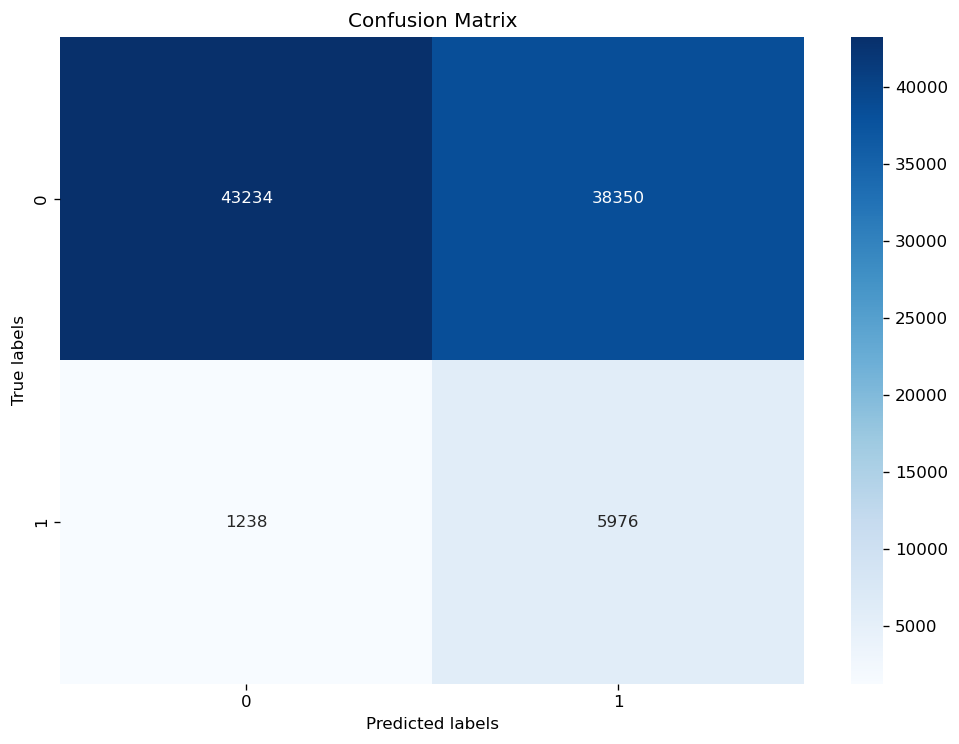

In [86]:
# Plotting the confusion matrix
plt.figure(figsize=(10,7),dpi=120)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### AUC ROC

In [87]:
y_prob = grid_search.predict_proba(X_test)[:, 1]

In [88]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

In [89]:
roc_auc = auc(fpr, tpr)

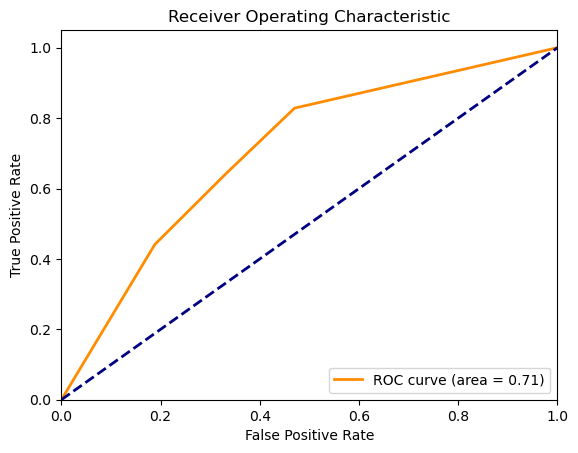

In [90]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Saving the model

In [91]:
import pickle

In [92]:
model = grid_search
filename = '../models/grid_search_decision_tree.sav'

with open(filename, 'wb') as file:
    pickle.dump(model, file)

In [93]:
from joblib import dump,load

# Assume 'onehot_model' is your trained OneHotEncoder and 'scaling_model' is your scaler (e.g., StandardScaler)
dump(oneh, '../models/onehot_model.joblib')
dump(scaler, '../models/scaling_model.joblib')

['../models/scaling_model.joblib']

In [94]:
import json

# Save to a JSON file
with open('../models/imput_dict.json', 'w') as f:
    json.dump(imputation_dict, f)

In [95]:
# Your list of column names
columns = list(X_train.columns)

# Save to a text file
with open('../models/columns.txt', 'w') as f:
    for column in columns:
        f.write(f"{column}\n")

In [96]:
from flask import Flask, request, send_from_directory, render_template
import pandas as pd
import os
import pickle
import numpy as np
import json
from joblib import load

app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = os.path.join(app.root_path, 'uploads')
app.config['RESULTS_FOLDER'] = os.path.join(app.root_path, 'results')
os.makedirs(app.config['UPLOAD_FOLDER'], exist_ok=True)
os.makedirs(app.config['RESULTS_FOLDER'], exist_ok=True)

# Load your model with an absolute path or relative to app.root_path
model_path = os.path.join(app.root_path, '../models/grid_search_decision_tree.sav')
model = pickle.load(open(model_path, 'rb'))

In [97]:
@app.route('/')
def index():
    return render_template('upload.html')  # Assuming you have an upload.html in your templates folder

@app.route('/upload', methods=['POST'])
def upload_file():
    if request.method == 'POST':
        # Save uploaded file
        f = request.files['file']
        filepath = os.path.join(app.config['UPLOAD_FOLDER'], f.filename)
        f.save(filepath)
        
        # Process and predict
        result_filepath = process_and_predict(filepath)
        
        # Return link to download the predictions
        return f'''
        Prediction complete. <a href="/results/{os.path.basename(result_filepath)}">Download Results</a>
        '''
    
def fill_nulls(data,imputation_dict):
    pack_list = ['K01', '102', '105', 'O01', '103', '101', '107', '301', '104','108', '109', 'M01']
    pack_list.remove('108')
    pack_list.remove('M01')
    
    for item in data['PACK'].unique():
        data.loc[data['PACK']== item,'AMOUNT_RUB_CLO_PRC'] = imputation_dict['AMOUNT_RUB_CLO_PRC'][item]
        data.loc[data['PACK']== item,'AMOUNT_RUB_NAS_PRC'] = imputation_dict['AMOUNT_RUB_NAS_PRC'][item]
        data.loc[data['PACK']== item,'TRANS_COUNT_NAS_PRC'] = imputation_dict['TRANS_COUNT_NAS_PRC'][item]
    
    for item in data['PACK'].unique():
        data.loc[data['PACK']== item,'AMOUNT_RUB_SUP_PRC'] = imputation_dict['AMOUNT_RUB_SUP_PRC'][item]
        data.loc[data['PACK']== item,'TRANS_COUNT_SUP_PRC'] = imputation_dict['TRANS_COUNT_SUP_PRC'][item]
        data.loc[data['PACK']== item,'TRANS_COUNT_ATM_PRC'] = imputation_dict['TRANS_COUNT_ATM_PRC'][item]
        data.loc[data['PACK']== item,'AMOUNT_RUB_ATM_PRC'] = imputation_dict['AMOUNT_RUB_ATM_PRC'][item]
        data.loc[data['PACK']== item,'CNT_TRAN_ATM_TENDENCY1M'] = imputation_dict['CNT_TRAN_ATM_TENDENCY1M'][item]
        data.loc[data['PACK']== item,'SUM_TRAN_ATM_TENDENCY1M'] = imputation_dict['SUM_TRAN_ATM_TENDENCY1M'][item]
    
    for item in data['PACK'].unique():
        data.loc[data['PACK']== item,'CNT_TRAN_SUP_TENDENCY3M'] = imputation_dict['CNT_TRAN_SUP_TENDENCY3M'][item]
        data.loc[data['PACK']== item,'SUM_TRAN_SUP_TENDENCY3M'] = imputation_dict['SUM_TRAN_SUP_TENDENCY3M'][item]
        data.loc[data['PACK']== item,'CNT_TRAN_ATM_TENDENCY3M'] = imputation_dict['CNT_TRAN_ATM_TENDENCY3M'][item]
        data.loc[data['PACK']== item,'AMOUNT_RUB_ATM_PRC'] = imputation_dict['AMOUNT_RUB_ATM_PRC'][item]
        data.loc[data['PACK']== item,'SUM_TRAN_ATM_TENDENCY3M'] = imputation_dict['SUM_TRAN_ATM_TENDENCY3M'][item]
        data.loc[data['PACK']== item,'TRANS_AMOUNT_TENDENCY3M'] = imputation_dict['TRANS_AMOUNT_TENDENCY3M'][item]
        data.loc[data['PACK']== item,'TRANS_CNT_TENDENCY3M'] = imputation_dict['TRANS_CNT_TENDENCY3M'][item]
        
    return data

def one_hot_encode(data):
    oneh = load('../models/onehot_model.joblib')
    col_names = oneh.get_feature_names_out()
    object_cols = data.select_dtypes(include=['object']).columns
    data_dummies = pd.DataFrame(oneh.transform(data[object_cols]),columns = col_names)
    data_dummies.index = data.index
    data = pd.merge(data,data_dummies,left_index=True,right_index=True)
    data.drop(columns = object_cols,inplace = True)
    return data

def scaling(data):
    scaler = load('../models/scaling_model.joblib')
    data_scaled = scaler.transform(data)
    data = pd.DataFrame(data_scaled, index=data.index, columns=data.columns)
    return data

def load_columns():
    with open('../models/columns.txt', 'r') as f:
        cols = [line.strip() for line in f]
    return list(cols)

def load_imput_dict():
    with open('../models/imput_dict.json', 'r') as f:
        # Load the data into a dictionary
        data_dict = json.load(f)
    return data_dict

def load_model(filename):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

def predict_data(data,cols, loaded_model):
    data['Prediction'] = loaded_model.predict(data[cols])
    return data

def pipeline(data, filename):
    print("Step 1:Fill Nulls\n\n")
    data = fill_nulls(data,load_imput_dict())
    print("Step 2:One Hot\n\n")
    data = one_hot_encode(data)
    print("Step 3:Scale\n\n")
    data = scaling(data)
    print("Step 4:Load Columns\n\n")
    cols = load_columns()
    print("Step 5:Load Model\n\n")
    loaded_model = load_model(filename)
    print("Step 6:Predict\n\n")
    data = predict_data(data,cols,loaded_model)
    
    data['ID'] = data.index
    data['Probabilities'] = loaded_model.predict_proba(data[cols])[:, 1]
    data = data[['ID','Prediction','Probabilities']]
    return data
    
def process_and_predict(filepath):
    data = pd.read_csv(filepath)
    predictions = pipeline(data,'../models/grid_search_decision_tree.sav')
    results_filename = os.path.basename(filepath).replace('.csv', '_results.csv')
    result_filepath = os.path.join(app.config['RESULTS_FOLDER'], results_filename)
    pd.DataFrame(predictions).to_csv(result_filepath, index=False)
    return results_filename

@app.route('/results/<filename>')
def results(filename):
    return send_from_directory(app.config['RESULTS_FOLDER'], filename)

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


We could see that we succesfully deployed our model with a preprocessing and predicting pipeline custom built by us.
Flask works properly even with a basic look, of course there is room for improvement like creating a simulator where the person could enter values and simulate if someone would be a fraud or not, or even enhancing the layout

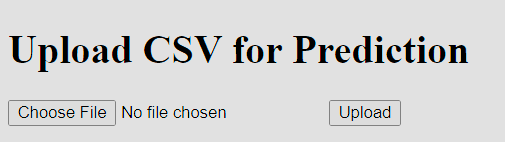

As you can see this is our final result for the HTML and when you upload something you get this, as long as the file has the right columns to predict

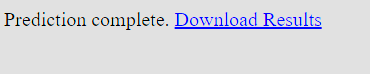